In [54]:
import cv2
import numpy as np
from PIL import Image
import dlib
import os

IMG_SIZE=227

def distance(a, b):
	return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def shape_to_normal(shape):
	shape_normal = []
	for i in range(0, 5):
		shape_normal.append((shape.part(i).x, shape.part(i).y))
	return shape_normal

def angle_opposite_to_line3(length_line1, length_line2, length_line3):
	cos_value = (length_line1**2 + length_line2**2 - length_line3**2) / (2*length_line2*length_line1)
	return np.arccos(cos_value)

def align_and_resize_image(img):
	##### align image ############################
	predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	x = 0
	y = 0
	w = gray.shape[0]
	h = gray.shape[1]
	rect=dlib.rectangle(x,y,w,h)
	shape = predictor(gray, rect)

	shape = shape_to_normal(shape)
	# shape has 5 point 4 nose 2 3 left eye 0 1 right eye
	# https://www.pyimagesearch.com/2018/04/02/faster-facial-landmark-detector-with-dlib/
	nose = shape[4]
	left_eye = [int(shape[2][0]+shape[3][0])/2,int(shape[2][1]+shape[3][1])/2]
	right_eye = [int(shape[0][0]+shape[1][0])/2,int(shape[0][1]+shape[1][1])/2]

	center_of_forehead = ((left_eye[0] + right_eye[0])/2, (left_eye[1] + right_eye[1])/2)

	center_image_top = (int((x + w) / 2), int((y + y) / 2))

	length_line1 = distance(center_of_forehead, nose)
	length_line2 = distance(center_image_top, nose)
	length_line3 = distance(center_image_top, center_of_forehead)

	angle = angle_opposite_to_line3(length_line1, length_line2, length_line3)

	if center_of_forehead[0]<=center_image_top[0]:
		angle = np.degrees(-angle)
	else:
		angle = np.degrees(angle)

	# print("angle is ",angle)
	img = Image.fromarray(img)
	img = np.array(img.rotate(angle))
	# ########################### Cropping of aligned image ###################################
	img=cv2.resize(img, (IMG_SIZE, IMG_SIZE))
	# print("===crpoing=",img.shape)
	return img


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive/My\ Drive/{location you want to move}

In [ ]:
%cd /gdrive/My\ Drive/Colab Notebooks/age gender classification
%ls

In [5]:
import tensorflow as tf
tf.__version__
model_gender = tf.keras.models.load_model('saved models/gender_prediction.h5')
# model_gender.summary()
model_age = tf.keras.models.load_model('saved models/age_prediction.h5')
# model_age.summary()

In [38]:
gender=["male","female","child"]
age=["0-2 Y","4-6 Y","8-13 Y","15-20 Y","25-32 Y","38-43 Y","48-53 Y","60+ Y"]
def predict_gender(img):
  img = np.expand_dims(img, axis=0)
  result = model_gender.predict_classes(img)
  return (gender[result[0]])

def predict_age(img):
  img = np.expand_dims(img, axis=0)
  result = model_age.predict_classes(img)
  return (age[result[0]])

Number of faces ===> 5


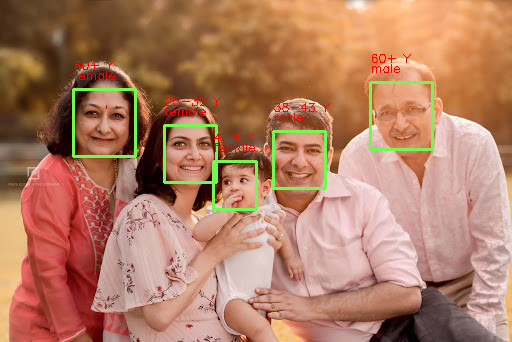

In [85]:
from google.colab.patches import cv2_imshow
# import imutils
ImagePath="p6.jpg"
img = cv2.imread(ImagePath)
# print(img.shape)#first one is height second one is width
# img = imutils.resize(img, width=512)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
image_copy = np.copy(img)
detector = dlib.get_frontal_face_detector()
faces = detector(gray, 1)#1 corresponds to number of time upsmaple the image
print("Number of faces ===>",len(faces))

for f in faces:
  x1=f.left()
  y1=f.top()-5
  x2=f.right()
  y2=f.bottom()
  cv2.rectangle(image_copy, (x1,y1), (x2, y2), (82,247,115), 2)
  # cv2_imshow(img[y1:y2, x1:x2])
  mod_img=align_and_resize_image(img[y1:y2, x1:x2])
  # cv2_imshow(mod_img)
  cv2.putText(image_copy, predict_age(mod_img), (x1, y1-20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)
  cv2.putText(image_copy, predict_gender(mod_img), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

cv2_imshow(image_copy)